![HydroSAR Banner](./NotebookAddOns/HydroSARbanner.jpg)

# Flood Mapping from Single Sentinel-1 SAR Images

**Franz J Meyer, University of Alaska Fairbanks**

This notebook presents the SAR-based flood mapping approach developed and used in the HydroSAR project. In its general concepts, the approach follows a methodology developed by the German Aerospace Center and published in [Sentinel-1-based flood mapping: a fully automated processing chain](https://www.tandfonline.com/doi/full/10.1080/01431161.2016.1192304) by Twele et al. The approach is based on radiometrically terrain corrected (RTC processed) Sentinel-1 SAR data and applies a dynamic thresholding method followed by fuzzy-logic-based post processing procedure. This notebook has both steps of this process implemented, but by default, the fuzzy logic step is deactivated to save processing time. The notebook will explain how the fuzzy logic post processing step can be activated should full performance processing be of interest. 

The approach is based on image amplitude data and is capable of detecting standing surface water. Note that flooding under vegetation will not be detected by this approach.

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/hydrosar':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "hydrosar" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select "hydrosar" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "hydrosar" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

# General Methodology and Workflow

The workflow of the Sentinel-1-based processing chain, as outlined in the figure below, is composed of the following main elements: 

1. **Find relevant SAR data** over your area of interest at the [Alaska Satellite Facility's SAR archive](https://search.asf.alaska.edu/#/)
1. **Perform geometric and radiometric terrain correction** using the RTC processing flow by [GAMMA Remote Sensing](https://www.gamma-rs.ch/)
1. **initial flood detection** using automatic thresholding
1. **fuzzy-logic-based classification refinement**
1. **>final classification into permanent and flood waters** using auxiliary data
1. **dissemination of the results**

***Steps 1 and 2*** of this workflow are operationally implemented in the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline (HyP3) environment and accessible to the public at the [ASF Search (Vertex)](https://search.asf.alaska.edu/#/).

<img style= "padding: 7px" src="https://courses.edx.org/asset-v1:AlaskaX+SAR-401+3T2020+type@asset+block@Watermappingworkflow2.jpg" width="70%"/>

# Flood Mapping Procedure

## Loading Python Libraries

In [3]:
%%capture

from pathlib import Path
from os import system
from typing import Tuple
import json
from shutil import rmtree

import pandas as pd
from osgeo import gdal
from osgeo import osr
import numpy as np
import rasterio
import pyproj
import skfuzzy

%matplotlib widget
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                               # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx

from ipyfilechooser import FileChooser

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()

## Write Some Helper Scripts

Write a function to pad an image, so it may be split into tiles with consistent dimensions

In [4]:
def pad_image(image: np.ndarray, to: int) -> np.ndarray:
    height, width = image.shape

    n_rows, n_cols = get_tile_row_col_count(height, width, to)
    new_height = n_rows * to
    new_width = n_cols * to

    padded = np.zeros((new_height, new_width))
    padded[:image.shape[0], :image.shape[1]] = image
    return padded

**Write a function to tile an image**

In [5]:
#def tile_image(image: np.ndarray, width: int = 200, height: int = 200) -> np.ndarray:
def tile_image(image: np.ndarray, width, height) -> np.ndarray:
    _nrows, _ncols = image.shape
    _strides = image.strides

    nrows, _m = divmod(_nrows, height)
    ncols, _n = divmod(_ncols, width)

    assert _m == 0, "Image must be evenly tileable. Please pad it first"
    assert _n == 0, "Image must be evenly tileable. Please pad it first"

    return np.lib.stride_tricks.as_strided(
        np.ravel(image),
        shape=(nrows, ncols, height, width),
        strides=(height * _strides[0], width * _strides[1], *_strides),
        writeable=False
    ).reshape(nrows * ncols, height, width)


**Write a function for Kittler-Illingworth Thresholding**

In [6]:
def Kittler(im):
    """
    The reimplementation of Kittler-Illingworth Thresholding algorithm by Bob Pepin
    Works on 8-bit images only
    Original Matlab code: https://www.mathworks.com/matlabcentral/fileexchange/45685-kittler-illingworth-thresholding
    Paper: Kittler, J. & Illingworth, J. Minimum error thresholding. Pattern Recognit. 19, 41–47 (1986).
    """
    test = im.ravel()
    tindex = np.nonzero(test>0)
    h,g = np.histogram(test[tindex],256,[0,256])
    h = h.astype(np.float)
    g = g.astype(np.float)
    g = g[:-1]
    c = np.cumsum(h)
    m = np.cumsum(h * g)
    s = np.cumsum(h * g**2)
    sigma_f = np.sqrt(s/c - (m/c)**2)
    cb = c[-1] - c
    mb = m[-1] - m
    sb = s[-1] - s
    sigma_b = np.sqrt(sb/cb - (mb/cb)**2)
    p =  c / c[-1]
    v = p * np.log10(sigma_f) + (1-p)*np.log10(sigma_b) - p*np.log10(p) - (1-p)*np.log10(1-p)
    v[~np.isfinite(v)] = np.inf
    idx = np.argmin(v)
    t = g[idx]
    return t

**Write a function for multi-class Expectation Maximization Thresholding to replace Kittler-Illingworth**

In [7]:
def EMSeg_opt(image, number_of_classes):
    image_copy = image.copy()
    image_copy2 = np.ma.filled(image.astype(float), np.nan) # needed for valid posterior_lookup keys
    image = image.flatten()
    minimum = np.amin(image)
    image = image - minimum + 1
    maximum = np.amax(image)

    size = image.size
    histogram = make_histogram(image)
    nonzero_indices = np.nonzero(histogram)[0]
    histogram = histogram[nonzero_indices]
    histogram = histogram.flatten()
    class_means = (
            (np.arange(number_of_classes) + 1) * maximum /
            (number_of_classes + 1)
    )
    class_variances = np.ones((number_of_classes)) * maximum
    class_proportions = np.ones((number_of_classes)) * 1 / number_of_classes
    sml = np.mean(np.diff(nonzero_indices)) / 1000
    iteration = 0
    while(True):
        class_likelihood = make_distribution(
            class_means, class_variances, class_proportions, nonzero_indices
        )
        sum_likelihood = np.sum(class_likelihood, 1) + np.finfo(
                class_likelihood[0][0]).eps
        log_likelihood = np.sum(histogram * np.log(sum_likelihood))
        for j in range(0, number_of_classes):
            class_posterior_probability = (
                histogram * class_likelihood[:,j] / sum_likelihood
            )
            class_proportions[j] = np.sum(class_posterior_probability)
            class_means[j] = (
                np.sum(nonzero_indices * class_posterior_probability)
                    / class_proportions[j]
            )
            vr = (nonzero_indices - class_means[j])
            class_variances[j] = (
                np.sum(vr *vr * class_posterior_probability)
                    / class_proportions[j] +sml
            )
            del class_posterior_probability, vr
        class_proportions = class_proportions + 1e-3
        class_proportions = class_proportions / np.sum(class_proportions)
        class_likelihood = make_distribution(
            class_means, class_variances, class_proportions, nonzero_indices
        )
        sum_likelihood = np.sum(class_likelihood, 1) + np.finfo(
                class_likelihood[0,0]).eps
        del class_likelihood
        new_log_likelihood = np.sum(histogram * np.log(sum_likelihood))
        del sum_likelihood
        if((new_log_likelihood - log_likelihood) < 0.000001):
            break
        iteration = iteration + 1
    del log_likelihood, new_log_likelihood
    class_means = class_means + minimum - 1
    s = image_copy.shape
    posterior = np.zeros((s[0], s[1], number_of_classes))
    posterior_lookup = dict()
    for i in range(0, s[0]):
        for j in range(0, s[1]):
            pixel_val = image_copy2[i,j] 
            if pixel_val in posterior_lookup:
                for n in range(0, number_of_classes): 
                    posterior[i,j,n] = posterior_lookup[pixel_val][n]
            else:
                posterior_lookup.update({pixel_val: [0]*number_of_classes})
                for n in range(0, number_of_classes): 
                    x = make_distribution(
                        class_means[n], class_variances[n], class_proportions[n],
                        image_copy[i,j]
                    )
                    posterior[i,j,n] = x * class_proportions[n]
                    posterior_lookup[pixel_val][n] = posterior[i,j,n]
    return posterior, class_means, class_variances, class_proportions

def make_histogram(image):
    image = image.flatten()
    indices = np.nonzero(np.isnan(image))
    image[indices] = 0
    indices = np.nonzero(np.isinf(image))
    image[indices] = 0
    del indices
    size = image.size
    maximum = int(np.ceil(np.amax(image)) + 1)
    #maximum = (np.ceil(np.amax(image)) + 1)
    histogram = np.zeros((1, maximum))
    for i in range(0,size):
        #floor_value = int(np.floor(image[i]))
        floor_value = np.floor(image[i]).astype(np.uint8)
        #floor_value = (np.floor(image[i]))
        if floor_value > 0 and floor_value < maximum - 1:
            temp1 = image[i] - floor_value
            temp2 = 1 - temp1
            histogram[0,floor_value] = histogram[0,floor_value] + temp1
            histogram[0,floor_value - 1] = histogram[0,floor_value - 1] + temp2
    histogram = np.convolve(histogram[0], [1,2,3,2,1])
    histogram = histogram[2:(histogram.size - 3)]
    histogram = histogram / np.sum(histogram)
    return histogram

def make_distribution(m, v, g, x):
    x = x.flatten()
    m = m.flatten()
    v = v.flatten()
    g = g.flatten()
    y = np.zeros((len(x), m.shape[0]))
    for i in range(0,m.shape[0]):
        d = x - m[i]
        amp = g[i] / np.sqrt(2*np.pi*v[i])
        y[:,i] = amp * np.exp(-0.5 * (d * d) / v[i])
    return y

**Write a function to calculate the number of rows and columns of tiles needed to tile an image to a given size**

In [8]:
def get_tile_row_col_count(height: int, width: int, tile_size: int) -> Tuple[int, int]:
    return int(np.ceil(height / tile_size)), int(np.ceil(width / tile_size))

**Write a function to extract the tiff dates from a wildcard path:**

In [9]:
def get_dates(paths):
    dates = []
    pths = list(paths.parent.rglob(paths.name))
    
    for p in pths:
        date = str(p).split('/')[-1].split("_")[0]
        dates.append(date)
    dates.sort()
    return dates

**Write a function to save a mask**

In [10]:
def write_mask_to_file(mask: np.ndarray, file_name: str, projection: str, geo_transform: str) -> None:
    (width, height) = mask.shape
    out_image = gdal.GetDriverByName('GTiff').Create(
        file_name, height, width, bands=1
    )
    out_image.SetProjection(projection)
    out_image.SetGeoTransform(geo_transform)
    out_image.GetRasterBand(1).WriteArray(mask)
    out_image.GetRasterBand(1).SetNoDataValue(0)
    out_image.FlushCache()
    
    
def gdal_write(ary, geoTransform, fileformat="GTiff", filename='jupyter_rocks.tif', format=gdal.GDT_Float64, nodata=None, srs_proj4='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'):
    '''gdal_write(ary, geoTransform, format="GTiff", filename='jupyter_rocks.tif', format=gdal.GDT_Float64 nodata=None, srs_proj4='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
    ary: 2D array.
    geoTransform: [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]
    format: "GTiff"     
    '''           
    if ary.ndim == 2:
        Ny, Nx = ary.shape
        Nb = 1;
    elif ary.ndim == 3:
        Ny, Nx, Nb = ary.shape
    else: 
        print("Input array has to be 2D or 3D.")
        return None
    
    driver = gdal.GetDriverByName(fileformat)
    ds = driver.Create(filename, Nx, Ny, Nb, gdal.GDT_Float64)

    #ds.SetGeoTransform( ... ) # define GeoTransform tuple
    # top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution
    ds.SetGeoTransform(geoTransform)    
    srs = osr.SpatialReference()
    srs.ImportFromProj4(srs_proj4)
    ds.SetProjection(srs.ExportToWkt())
    if nodata is not None:
        ds.GetRasterBand(1).SetNoDataValue(0)
    if Nb == 1:
        ds.GetRasterBand(1).WriteArray(ary)
    else:
        for b in range(Nb):
            ds.GetRasterBand(b+1).WriteArray(ary[:,:,b])
    ds = None

    
def get_proj4(filename):
    f = rasterio.open(filename)
    return pyproj.Proj(f.crs, preserve_units=True)  #used in pysheds
    
    
def gdal_read(filename, ndtype=np.float64):
    '''
    z=readData('/path/to/file')
    '''
    filename = str(filename)
    ds = gdal.Open(filename) 
    return np.array(ds.GetRasterBand(1).ReadAsArray()).astype(ndtype);


def gdal_get_geotransform(filename):
    '''
    [top left x, w-e pixel resolution, rotation, top left y, rotation, n-s pixel resolution]=gdal_get_geotransform('/path/to/file')
    '''
    filename = str(filename)
    #http://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    ds = gdal.Open(filename)
    return ds.GetGeoTransform()


def fill_nan(arr):
    """
    filled_arr=fill_nan(arr)
    Fills Not-a-number values in arr using astropy. 
    """    
    kernel = astropy.convolution.Gaussian2DKernel(x_stddev=3) #kernel x_size=8*stddev
    arr_type = arr.dtype          
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        while np.any(np.isnan(arr)):
            arr = astropy.convolution.interpolate_replace_nans(arr.astype(float), kernel, convolve=astropy.convolution.convolve)
    return arr.astype(arr_type) 

## Load SAR Data Sets to Process

In [11]:
def get_tiff_paths(paths: str) -> list:
    tiff_paths = !ls $paths | sort -t_ -k5,5
    return tiff_paths

**Reading a SAR Data Stack:**

Choose the folder where you stored some SAR images. They need to have both **VH** and **VV** polarization. 

In [12]:
fc = FileChooser('/home/jovyan/notebooks')
display(fc)

FileChooser(path='/home/jovyan/notebooks', filename='', title='', show_hidden=False, select_desc='Select', cha…

In [13]:
tiff_dir = Path(fc.selected)

**Create a directory in which to store the water masks**

In [14]:
mask_directory = tiff_dir.parent/'Water_Masks'

if not mask_directory.exists():
    mask_directory.mkdir()
    
paths = tiff_dir/"*_V*.tif*"
if tiff_dir.exists():
    tiff_paths = get_tiff_paths(paths)

In [15]:
class SARDualPolError(Exception):
    """
    Raise when expecting dual-pol SAR data
    but single-pol found instead
    """
    pass

vv_wild = tiff_dir/'*_VV.tif*'
vh_wild = tiff_dir/'*_VH.tif*'

if tiff_dir.exists():
    vh_paths = get_tiff_paths(vh_wild)
    vv_paths = get_tiff_paths(vv_wild)

for i, pth in enumerate(vv_paths):
    vh = f"{pth.split('_V')[0]}_VH{Path(pth).suffix}"
    if vh not in vh_paths:
        raise SARDualPolError(f"Found {pth} but not {vh}")        
for i, pth in enumerate(vh_paths):
    vv = f"{pth.split('_V')[0]}_VV{Path(pth).suffix}"
    if vv not in vv_paths:
        raise SARDualPolError(f"Found {pth} but not {vv}")
        
print(f"Success: dual-pol data found")

Success: dual-pol data found


**Write a function to create a dictionary containing lists of each vv/vh pair**

In [16]:
def group_polarizations(tiff_paths: list) -> dict:
    pths = {}
    for tiff in tiff_paths:
        product_name = tiff.split('.')[0][:-2]
        if product_name in pths:
            pths[product_name].append(tiff)
        else:
            pths.update({product_name: [tiff]})
            pths[product_name].sort()
    return pths

**Write a function to confirm the presence of both VV and VH images in all image sets**

In [17]:
def confirm_dual_polarizations(paths: dict) -> bool:
    for p in paths:
        if len(paths[p]) == 2:
            if ('vv' not in paths[p][1] and 'VV' not in paths[p][1]) or \
            ('vh' not in paths[p][0] and 'VH' not in paths[p][0]):
                return False
    return True   

**Create a dictionary of VV/VH pairs and check it for completeness**

In [18]:
grouped_pths = group_polarizations(tiff_paths)
if not confirm_dual_polarizations(grouped_pths):
    print("ERROR: AI_Water requires both VV and VH polarizations.")
else:
    print("Confirmed presence of VV and VH polarities for each product.")
    
#print(grouped_pths) #uncomment to print VV/VH path pairs

Confirmed presence of VV and VH polarities for each product.


## Load HAND Layer for your AOI and Create HAND-Exclusion Mask (HAND-EM)

**Note:** This notebook expects the HAND layer to be of the same extent, resolution, and projection as the SAR image stack. This can easily be fixed in future versions of the notebook. The HAND layer you will be using meets all of these requirements.

**Please pick the `.tif` file that you generated in `3-Big_Hand_notebook.ipynb`, probably saved in you DEM folder**

In [19]:
print("Choose your HAND layer:")
f = FileChooser(Path.cwd())
display(f)

Choose your HAND layer:


FileChooser(path='/home/jovyan/notebooks/Hydrosar', filename='', title='', show_hidden=False, select_desc='Sel…

In [20]:
class NoHANDLayerException(Exception):
    """
    Raised when expecting path to HAND layer but none found
    """
    pass

#load HAND and derive HAND-EM
Hthresh = 15

HAND_file = Path(f.selected)
print(f"Selected HAND: {HAND_file}")
try:
    HAND_gT = gdal_get_geotransform(HAND_file)
except AttributeError:
    raise NoHANDLayerException("You must select a HAND layer in the previous code cell")
HAND_proj4 = get_proj4(HAND_file)
info = (gdal.Info(str(HAND_file), format='json'))
info = info['coordinateSystem']['wkt']
Hzone = info.split('ID')[-1].split(',')[1][0:-2]
Hproj_type = info.split('ID')[-1].split('"')[1]
HAND=gdal_read(HAND_file)
hand = np.nan_to_num(HAND)

# Create Binary HAND-EM
Hmask = hand < Hthresh
handem = np.zeros_like(hand)
sel = np.ones_like(hand)
handem[Hmask] = sel[Hmask]

Selected HAND: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif


/home/jovyan/.local/envs/hydrosar/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [21]:
grouped_pths

{'/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220512_': ['/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220512_VH.tiff',
  '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220512_VV.tiff'],
 '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220605_': ['/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220605_VH.tiff',
  '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220605_VV.tiff'],
 '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220617_': ['/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220617_VH.tiff',
  '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220617_VV.tiff'],
 '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220629_': ['/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220629_VH.tiff',
  '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220629_VV.tiff'],
 '/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220711_': ['/home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Crop

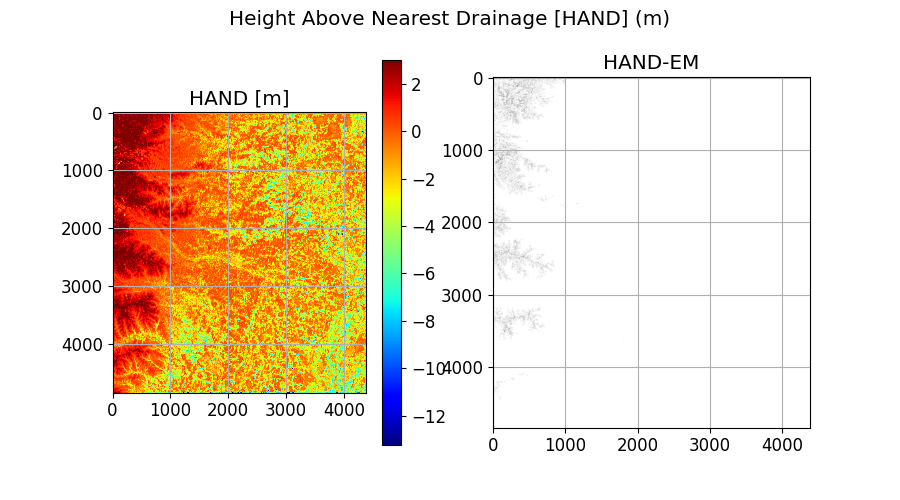

In [22]:
fig = plt.figure(figsize=(9, 5))
plt.suptitle('Height Above Nearest Drainage [HAND] (m)')
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
vmin = np.percentile(hand, 5)
vmax = np.percentile(hand, 95)
hh = ax1.imshow(hand, cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_title('HAND [m]')
ax1.grid()
fig.colorbar(hh,ax=ax1)
ax2.imshow(handem, cmap='gray')
ax2.set_title('HAND-EM')
ax2.grid()

## Do Initial Flood Mapping using Adaptive Dynamic Thresholding

**A bit of background on the approach:**

An automatic tile-based thresholding procedure (Martinis, Twele, and Voigt 2009) is used to generate an initial land/water classification. The selection of tiles is performed on a bilevel quadtree structure with parent level $L^+$ and child level $L^−$:
    
1. Firstly, the entire image is separated into quadratic non-overlapping parent tiles on level $L^+$ with a size of $100 \times 100$ pixels. Each parent object is further represented by four quadratic child objects on a second level $L^−$. The tile selection process is based on statistical hierarchical relations between parent and child objects. 
2. A number of parent tiles is automatically selected that offer the highest (>95% quantile) coefficient of variation $\frac{\sigma}{\mu}$ on $L^+$ of the mean backscatter values of the respective child objects on $L^−$. This criterion serves as a measure of the degree of variation within a tile and can therefore be used as an indicator of the probability that a tile is characterized by spatial inhomogeneity and contain more than one semantic class. The selected parent objects should also have a mean individual backscatter value lower than the mean of all parent tiles on $L^+$. This ensures that tiles lying on the boundary between water and no water areas are selected. In case that no tiles fulfil these criteria, the tile size on $L^+$ and $L^−$ is halved and the quantile for the tile selection is reduced to 90% to guarantee a successful tile selection also in data with a relatively low extent of water surfaces or with smaller dispersed water bodies. 
3. To improve the robustness of the automatic threshold derivation we restrict the tile selection in Step (3) to only pixels situated in flood-prone regions as defined by a HAND-based binary Exclustion Mask (HAND-EM). To create the HAND-EM layer, a threshold is applied to a Height Above Nearest Drainage(HAND) data set to identify non-flood prone areas. A threshold value of $\geq 15m$ is used. The HAND-EM further is shrunk by one pixel using an 8-neighbour function to account for potential geometric inaccuracies between the exclude layer and SAR data. Tiles are only considered in case less than 20% of its data pixels are excluded by HAND-EM. 
4. Out of the number of the initially selected tiles, a limited number of $N$ parent tiles are finally chosen for threshold computation. This selection is accomplished by ranking the parent tiles according to the standard deviation of the mean backscatter values of the respective child objects. Tiles with the highest values are chosen. Extensive testing yielded that $N = 5$ is a sufficient number of parent tiles for threshold computation. 
5. A multi-mode Expectation Maximization thresholding approach is then employed to derive local threshold values using a cost function which is based on the statistical parameterization of the sub-histograms of all selected tiles. In order to derive a global (i.e. scenebased) threshold, the locally derived thresholds are combined by computing their arithmetic mean.
6. Using the dynamically calculated threshold, both the VV and VH scenes are thresholded for creating an initial surface water extent map.
7. The surface water extent maps derived from the VV and VH channel are combined to arrive at a combined intial surface water extent mask that is further refined in a post processing (Section 2.6).

**Now Let's do the Work:**

In [23]:
# define some variables you might want to change
precentile = 0.95        # Standard deviation percentile threshold for pivotal tile selection
tilesize = 100           # Setting tile size to use in thresholding algorithm
tilesize2 = 50
Hpick = 0.8              # Threshold for required fraction of valid HAND-EM pixels per tile
vv_corr = -15.0          # VV threshold to use if threshold calculation did not succeed
vh_corr = -23.0          # VH threshold to use if threshold calculation did not succeed

# Tile up HAND-EM data
handem_p = pad_image(handem, tilesize)
hand_tiles = tile_image(handem_p,width=tilesize,height=tilesize)
Hsum = np.sum(hand_tiles, axis=(1,2))
Hpercent = Hsum/(tilesize*tilesize)

# Now do adaptive threshold selection
vv_thresholds = np.array([])
vh_thresholds = np.array([])
floodarea = np.array([])
vh_thresholds_corr = np.array([])
vv_thresholds_corr = np.array([])

posterior_lookup = dict()

for i, pair in enumerate(grouped_pths):
    print(f"Processing pair {i+1} of {len(grouped_pths)}")
    for tiff in grouped_pths[pair]:
        f = gdal.Open(tiff)
        img_array = f.ReadAsArray()
        original_shape = img_array.shape
        n_rows, n_cols = get_tile_row_col_count(*original_shape, tile_size=tilesize)
        print(f'tiff: {tiff}')
        if 'vv' in tiff or 'VV' in tiff:
            vv_array = pad_image(f.ReadAsArray(), tilesize)
            invalid_pixels = np.nonzero(vv_array == 0.0)
            vv_tiles = tile_image(vv_array,width=tilesize,height=tilesize)
            a = np.shape(vv_tiles)
            vv_std = np.zeros(a[0])
            vvt_masked = np.ma.masked_where(vv_tiles==0, vv_tiles)
            vv_picktiles = np.zeros_like(vv_tiles)
            for k in range(a[0]):
                vv_subtiles = tile_image(vvt_masked[k,:,:],width=tilesize2,height=tilesize2)
                vvst_mean = np.ma.mean(vv_subtiles, axis=(1,2))
                vvst_std = np.ma.std(vvst_mean)
                vv_std[k] = np.ma.std(vvst_mean) 
            
            # find tiles with largest standard deviations
            vv_mean = np.ma.median(vvt_masked, axis=(1,2))
            x_vv = np.sort(vv_std/vv_mean)
            y_vv = np.arange(1, x_vv.size+1) / x_vv.size
            
            percentile2 = precentile
            sort_index = 0
            while np.size(sort_index) < 5: 
                threshold_index_vv = np.ma.min(np.where(y_vv>percentile2))
                threshold_vv = x_vv[threshold_index_vv]
                #sd_select_vv = np.nonzero(vv_std/vv_mean>threshold_vv)
                s_select_vv = np.nonzero(vv_std/vv_mean>threshold_vv) 
                h_select_vv = np.nonzero(Hpercent > Hpick)               # Includes HAND-EM in selection
                sd_select_vv = np.intersect1d(s_select_vv, h_select_vv)
            
                # find tiles with mean values lower than the average mean
                omean_vv = np.ma.median(vv_mean[h_select_vv[0][h_select_vv[0]<vv_mean.shape[0]]])
                mean_select_vv = np.nonzero(vv_mean<omean_vv)
            
                # Intersect tiles with large std with tiles that have small means
                msdselect_vv = np.intersect1d(sd_select_vv, mean_select_vv)
                sort_index = np.flipud(np.argsort(vv_std[msdselect_vv]))
                percentile2 = percentile2 - 0.01
            finalselect_vv = sort_index[0:5]
            
            # find local thresholds for 5 "best" tiles in the image
            l_thresh_vv = np.zeros(5)
            EMthresh_vv = np.zeros(5)
            temp = np.ma.masked_where(vv_array==0, vv_array)
            dbvv = np.ma.log10(temp)+30
            scaling = 256/(np.mean(dbvv) + 3*np.std(dbvv))
            #scaling = 256/(np.mean(vv_array) + 3*np.std(vv_array))
            dbtile = np.ma.log10(vvt_masked)+30
            for k in range(5):
                test = dbtile[msdselect_vh[finalselect_vh[k]]] * scaling
                #test = vvt_masked[msdselect_vv[finalselect_vv[k]]] * scaling
                A = np.around(test)
                A = A.astype(int)
                #t_thresh = Kittler(A)
                [posterior, cm, cv, cp] = EMSeg_opt(A, 3)
                sorti = np.argsort(cm)
                cms = cm[sorti]
                cvs = cv[sorti]
                cps = cp[sorti]
                xvec = np.arange(cms[0],cms[1],step=.05)
                x1 = make_distribution(cms[0], cvs[0], cps[0], xvec)
                x2 = make_distribution(cms[1], cvs[1], cps[1], xvec)
                dx = np.abs(x1 - x2)
                diff1 = posterior[:,:,0] - posterior[:,:,1]
                t_ind = np.argmin(dx)
                EMthresh_vv[k] = xvec[t_ind]/scaling
                
                #l_thresh_vv[k] = t_thresh / scaling
                #dbtile = np.ma.log10(vvt_masked)+30
                
                # Mark Tiles used for Threshold Estimation
                vv_picktiles[msdselect_vh[finalselect_vh[k]],:,:]= np.ones_like(vv_tiles[msdselect_vh[finalselect_vh[k]],:,:])
            
            # Calculate best threshold for VV and VH as the mean of the 5 thresholds calculated in the previous section 
            #m_thresh_vv = np.median(l_thresh_vv)
            #print(EMthresh_vv-30)
            EMts = np.sort(EMthresh_vv)
            #m_thresh_vv = np.median(EMthresh_vv)
            m_thresh_vv = np.median(EMts[0:4])
            print("Best VV Flood Mapping Threshold [dB]: %.2f" % (10*(m_thresh_vv-30)))
            print(" ")
            
            # Derive flood mask using the best threshold
            if m_thresh_vv < (vv_corr/10.0+30):
                change_mag_mask_vv = np.ma.masked_where(dbvv==0, dbvv) < m_thresh_vv
                vv_thresholds_corr = np.append(vv_thresholds_corr, 10.0*(m_thresh_vv-30))
                #change_mag_mask_vv = np.ma.masked_where(vv_array==0, vv_array) < m_thresh_vv
            else:
                change_mag_mask_vv = np.ma.masked_where(dbvv==0, dbvv) < (vv_corr/10.0+30)
                vv_thresholds_corr = np.append(vv_thresholds_corr, vv_corr)
            
            # Create Binary masks showing flooded pixels as "1"s
            flood_vv = np.zeros_like(vv_array)
            sel = np.ones_like(vv_array)
            flood_vv[change_mag_mask_vv] = sel[change_mag_mask_vv]
            np.putmask(flood_vv,vv_array==0 , 0)
            
            # Export flood maps as GeoTIFFs
            filename, ext = Path(tiff).name.split('.')
            outfile = f"{mask_directory}/{filename}_water_mask.{ext}"
            write_mask_to_file(flood_vv, outfile, f.GetProjection(), f.GetGeoTransform())
        
        else:
            vh_array = pad_image(f.ReadAsArray(), tilesize)
            invalid_pixels = np.nonzero(vh_array == 0.0)
            vh_tiles = tile_image(vh_array,width=tilesize,height=tilesize)
            a = np.shape(vh_tiles)
            vh_std = np.zeros(a[0])
            vht_masked = np.ma.masked_where(vh_tiles==0, vh_tiles)
            vh_picktiles = np.zeros_like(vh_tiles)
            for k in range(a[0]):
                vh_subtiles = tile_image(vht_masked[k,:,:],width=tilesize2,height=tilesize2)
                vhst_mean = np.ma.mean(vh_subtiles, axis=(1,2))
                vhst_std = np.ma.std(vhst_mean)
                vh_std[k] = np.ma.std(vhst_mean)
            
            # find tiles with largest standard deviations
            vh_mean = np.ma.median(vht_masked, axis=(1,2))
            x_vh = np.sort(vh_std/vh_mean)
            xm_vh = np.sort(vh_mean)
            #x_vh = np.sort(vh_std)            
            y_vh = np.arange(1, x_vh.size+1) / x_vh.size
            ym_vh = np.arange(1, xm_vh.size+1) / xm_vh.size
            
            percentile2 = precentile
            sort_index = 0
            while np.size(sort_index) < 5:
                threshold_index_vh = np.ma.min(np.where(y_vh>percentile2))
                threshold_vh = x_vh[threshold_index_vh]
                #sd_select_vh = np.nonzero(vh_std/vh_mean>threshold_vh)
                s_select_vh = np.nonzero(vh_std/vh_mean>threshold_vh) 
                h_select_vh = np.nonzero(Hpercent > Hpick)               # Includes HAND-EM in selection
                sd_select_vh = np.intersect1d(s_select_vh, h_select_vh)
    
                # find tiles with mean values lower than the average mean 
                omean_vh = np.ma.median(vh_mean[h_select_vh[0][h_select_vh[0]<vh_mean.shape[0]]])
                mean_select_vh = np.nonzero(vh_mean<omean_vh)
            
                # Intersect tiles with large std with tiles that have small means
                msdselect_vh = np.intersect1d(sd_select_vh, mean_select_vh)
                sort_index = np.flipud(np.argsort(vh_std[msdselect_vh]))
                percentile2 = percentile2 - 0.01
            finalselect_vh = sort_index[0:5]
    
    
            # find local thresholds for 5 "best" tiles in the image
            l_thresh_vh = np.zeros(5)
            EMthresh_vh = np.zeros(5)
            temp = np.ma.masked_where(vh_array==0, vh_array)
            dbvh = np.ma.log10(temp)+30
            scaling = 256/(np.mean(dbvh) + 3*np.std(dbvh))
            #scaling = 256/(np.mean(vh_array) + 3*np.std(vh_array))
            dbtile = np.ma.log10(vht_masked)+30
            for k in range(5):
                test = dbtile[msdselect_vh[finalselect_vh[k]]] * scaling
                #test = vht_masked[msdselect_vh[finalselect_vh[k]]] * scaling
                A = np.around(test)
                A = A.astype(int)
                #t_thresh = Kittler(A)
                [posterior, cm, cv, cp] = EMSeg_opt(A, 3)
                sorti = np.argsort(cm)
                cms = cm[sorti]
                cvs = cv[sorti]
                cps = cp[sorti]
                xvec = np.arange(cms[0],cms[1],step=.05)
                x1 = make_distribution(cms[0], cvs[0], cps[0], xvec)
                x2 = make_distribution(cms[1], cvs[1], cps[1], xvec)
                dx = np.abs(x1 - x2)
                diff1 = posterior[:,:,0] - posterior[:,:,1]
                t_ind = np.argmin(dx)
                EMthresh_vh[k] = xvec[t_ind]/scaling
                
                #l_thresh_vh[k] = t_thresh / scaling
                
                
                # Mark Tiles used for Threshold Estimation
                vh_picktiles[msdselect_vh[finalselect_vh[k]],:,:]= np.ones_like(vh_tiles[msdselect_vh[finalselect_vh[k]],:,:])
    
            # Calculate best threshold for VV and VH as the mean of the 5 thresholds calculated in the previous section 
            #m_thresh_vh = np.median(l_thresh_vh)
            #print(EMthresh_vh-30)
            EMts = np.sort(EMthresh_vh)
            #m_thresh_vh = np.median(EMthresh_vh)
            m_thresh_vh = np.median(EMts[0:4])
            print("Best VH Flood Mapping Threshold [dB]: %.2f" % (10*(m_thresh_vh-30)))
            print(" ")
    
            # Derive flood mask using the best threshold
            maskedarray = np.ma.masked_where(dbvh==0, dbvh)
            
            #maskedarray = np.ma.masked_where(vh_array==0, vh_array)
            if m_thresh_vh < (vh_corr/10.0+30):
                change_mag_mask_vh = maskedarray < m_thresh_vh
                vh_thresholds_corr = np.append(vh_thresholds_corr, 10.0*(m_thresh_vh-30)) 
                #change_mag_mask_vv = np.ma.masked_where(vv_array==0, vv_array) < m_thresh_vv
            else:
                change_mag_mask_vh = maskedarray < (vh_corr/10.0+30)
                vh_thresholds_corr = np.append(vh_thresholds_corr, vh_corr) 
            # change_mag_mask_vh = vh_array < m_thresh_vh
    
            # Create Binary masks showing flooded pixels as "1"s
            sel = np.ones_like(vh_array)
            flood_vh = np.zeros_like(vh_array)
            flood_vh[change_mag_mask_vh] = sel[change_mag_mask_vh]
            np.putmask(flood_vh,vh_array==0 , 0)

            # Export flood maps as GeoTIFFs
            filename, ext = Path(tiff).name.split('.')
            outfile = f"{mask_directory}/{filename}_water_mask.{ext}"
            write_mask_to_file(flood_vh, outfile, f.GetProjection(), f.GetGeoTransform())
        
    
    # Create Maps (Pickfiles) that show which tiles were used for adaptive threshold calculation
    vv_picks = vv_picktiles.reshape((n_rows, n_cols, tilesize, tilesize)) \
                .swapaxes(1, 2) \
                .reshape(n_rows * tilesize, n_cols * tilesize)  # yapf: disable
    vh_picks = vh_picktiles.reshape((n_rows, n_cols, tilesize, tilesize)) \
                .swapaxes(1, 2) \
                .reshape(n_rows * tilesize, n_cols * tilesize)  # yapf: disable
    
    # Write Pickfiles to GeoTIFFs
    #outfile = f"{mask_directory}/{filename[:-3]}_vv_pickfile.{ext}"
    #write_mask_to_file(vv_picks, outfile, f.GetProjection(), f.GetGeoTransform())
    #outfile = f"{mask_directory}/{filename[:-3]}_vh_pickfile.{ext}"
    #write_mask_to_file(vh_picks, outfile, f.GetProjection(), f.GetGeoTransform())

    # Combine VV and VH flood maps to produce a combined flood mapping product
    comb = flood_vh + flood_vv
    comb_mask = comb > 0
    flood_comb = np.zeros_like(vv_array)
    flood_comb[comb_mask] = sel[comb_mask]
    filename, ext = Path(tiff).name.split('.')
    outfile = f"{mask_directory}/{filename[:-3]}_water_mask_combined.{ext}"
    write_mask_to_file(flood_comb, outfile, f.GetProjection(), f.GetGeoTransform())
    
    # Create Information on Thresholds used as well as Flood extent information in km2
    vv_thresholds = np.append(vv_thresholds, 10.0*(m_thresh_vv-30))
    vh_thresholds = np.append(vh_thresholds, 10.0*(m_thresh_vh-30)) 
    floodarea = np.append(floodarea,(np.sum(flood_comb)*30**2./(1000**2)))

Processing pair 1 of 10
tiff: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220512_VH.tiff
Best VH Flood Mapping Threshold [dB]: -15.99
 
tiff: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220512_VV.tiff
Best VV Flood Mapping Threshold [dB]: -8.85
 
Processing pair 2 of 10
tiff: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220605_VH.tiff
Best VH Flood Mapping Threshold [dB]: -20.09
 
tiff: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220605_VV.tiff
Best VV Flood Mapping Threshold [dB]: -11.41
 
Processing pair 3 of 10
tiff: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220617_VH.tiff
Best VH Flood Mapping Threshold [dB]: -20.19
 
tiff: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220617_VV.tiff
Best VV Flood Mapping Threshold [dB]: -12.08
 
Processing pair 4 of 10
tiff: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220629_VH.tiff
Best VH Flood Mapping Threshold [dB]: -20.21
 
tiff: /home/jovyan/notebooks/Hydrosar

## Fuzzy Logic Post Processing to Clean up Initial Surface Water Extent Map

1. The radar cross section in a pixel relative to the determined detection threshold.
1. The HAND elevation (surface elevation relative to the nearest dranage basin).
1. The surface slope.
1. The size of a detected flood feature.

Fuzzy membership functions are calculated for each of these four indicators using a Z-shaped activation function. Membership functions are combined using arithmetric averaging to form a final decision map. This map is then thresholded using a fuzzy threshold of 0.45.

**Upper and lower thresholds for the fuzzy activation functions are calculated as follows:**

1. **RCS:** $\begin{Bmatrix} 
    x_{u,RCS} & = & \tau_g \\
    x_{l,RCS} & = & \mu_{\sigma^0(\tau_g)}
    \end{Bmatrix}$ 
    with $\sigma^0(\tau_g)$ = initial flood classification and flood mapping threshold $\tau_g$.<br><br></li>
1. **HAND:** $\begin{Bmatrix} 
    x_{u,HAND} & = & \mu_{HAND(water)} + 3 \cdot \sigma_{HAND(water)} \\
    x_{l,HAND} & = & \mu_{HAND(water)}
    \end{Bmatrix}$. This is a departure from <cite><a href="https://www.sciencedirect.com/science/article/pii/S0924271614001981" target="_blank"><i>the paper</i></a> by Martinis et al. (2015)</cite>.<br><br></li>
1. **Surface slope $\alpha$:** $\begin{Bmatrix} 
    x_{u,\alpha} & = & 0^{\circ} \\
    x_{l,\alpha} & = & 15^{\circ}
    \end{Bmatrix}$.<br><br></li>
1. **Area $A$:**$\begin{Bmatrix} 
    x_{u,A} & = & 10px \\
    x_{l,A} & = & 3px
    \end{Bmatrix}$. These threshold values are different differently than in [the paper by Martinis et al. (2015)](https://www.sciencedirect.com/science/article/pii/S0924271614001981)
    
---

**Note:** By default, this post-processing step is not used in this notebook. Deactivating the post processing procedure is done to save processing time for this course exercise. Feel free to activate this step by setting the `do_PP` flag to `True` in the following code cell.

In [24]:
do_PP = True

---
**This next code cell does the actual fuzzy logic-based post processing work:**

In [ ]:
if do_PP:
    import skimage.measure
    import skimage.color
    from skimage import morphology
    from skimage import filters
    import time
    import astropy.convolution
    import warnings #Suppress warnings on occasion
    from tqdm.auto import tqdm

    vvcount = 0
    vhcount = 0
    floodareaPP = np.array([])

    print('FUZZY LOGIC POST PROCESSING TO REFINE INITIAL SURFACE WATER EXTENT MAPS:')
    print(' ')

    for pair in grouped_pths:
        for tiff in grouped_pths[pair]:
            print(type(tiff))
            
            start = time.time()
            print('-----------------------------------------------------------------------------------')
            print(f'Image: {tiff}')
            resampled_dem_path=f'{tiff_dir}/resamp_dem.tif'
            f = gdal.Open(tiff)
            img_array = f.ReadAsArray()
            original_shape = img_array.shape
            img_array = 0     # free up RAM
            radar_array = pad_image(f.ReadAsArray(), tilesize)
            temp = np.ma.masked_where(radar_array==0, radar_array)
            np.seterr(divide='ignore')
            np.seterr(invalid='ignore')
            dbarray = np.log10(temp)+30
            del temp

            # ------------------------------------------------------------#
            # Loading Water Mask File                                     #
            #-------------------------------------------------------------#
            filename, ext = Path(tiff).name.split('.')
            waterfile = f"{mask_directory}/{filename}_water_mask.{ext}"
            h = gdal.Open(waterfile)
            maskimage = h.ReadAsArray()


            print('   - Extracting Relevant Subset from HAND Layer ...')

            info1 = (gdal.Info(tiff, options = ['-json']))
            info1 = json.dumps(info1)
            ul = (json.loads(info1))['cornerCoordinates']['upperLeft']
            lr = (json.loads(info1))['cornerCoordinates']['lowerRight']
            coordsys = (json.loads(info1))['coordinateSystem']['wkt']
            Szone = coordsys.split('ID')[-1].split(',')[1][0:-2]
            Sproj_type = coordsys.split('ID')[-1].split('"')[1]

            west= ul[0]
            east= lr[0]
            south= lr[1]
            north= ul[1]

            cmd_resamp=f"gdalwarp -overwrite -s_srs {Hproj_type}:"\
            f"{Hzone} -t_srs EPSG:{Szone} -te {west} {south} {east} {north} -ts {original_shape[1]} {original_shape[0]} -r lanczos {HAND_file} {resampled_dem_path}"
            #print(cmd_resamp)
            system(cmd_resamp)

            g = gdal.Open(resampled_dem_path)
            hand = pad_image(g.ReadAsArray(), tilesize)

            print('   - Interpolate NaNs in HAND Layer ...')

            hand_interp= fill_nan(hand)
            del hand

            print('   - Calculate DEM (HAND) Slope magnitude ...')

            vgrad = np.gradient(hand_interp)
            mag = np.sqrt(vgrad[0]**2 + vgrad[1]**2)
            geotransform = g.GetGeoTransform()
            res = geotransform[1]
            slope = np.arctan(mag/res)/np.pi*180

            print('   - Segment initial flood mask to calculate area of connected patches ...')

            # Here an attempt to perform a sequence of opening and closing steps to 
            # reduce the number of segments in the inital flood maps and speed up the next processing steps
            med = filters.median(maskimage, morphology.disk(2))
            selem = morphology.disk(3)
            closed = skimage.morphology.closing(med, selem)
            labeled_image = skimage.measure.label(closed, connectivity=2)
            label_areas = np.bincount(labeled_image.ravel())[1:]


            # Define upper and lower limit of the Z fuzzy activation function

            print('   - Now Calculate Fuzzy Weights ...')

            ## sigma zero upper and lower fuzzy threshold calculation
            maskedarray = np.ma.masked_where((maskimage==0) | (radar_array < 0), radar_array)
            db_lowerlimit = np.log10(np.ma.median(maskedarray))+30
            if 'vv' in tiff or 'VV' in tiff:
                db_upperlimit = (vv_thresholds_corr[vvcount]/10.0+30)
                vvcount = vvcount + 1
            else:
                db_upperlimit = (vh_thresholds_corr[vhcount]/10.0+30)
                vhcount = vhcount + 1

            ## HAND upper and lower fuzzy threshold calculation
            maskedarray = np.ma.masked_where(maskimage==0, hand_interp)
            ma2 = np.ma.masked_where(maskedarray > np.percentile(maskedarray.compressed(), 90), maskedarray)
            hand_lowerlimit = np.ma.median(np.ma.masked_invalid(ma2))
            hand_upperlimit = hand_lowerlimit + (np.ma.std(np.ma.masked_invalid(ma2)) + 3.5)*np.ma.std(np.ma.masked_invalid(ma2))
            hand_upperlimit = hand_lowerlimit + 3.0*(np.ma.std(np.ma.masked_invalid(ma2)))

            # Create vector spanning all possible values for db, HAND, Slope, and Area values for the selected data set
            x_db = np.arange(np.min(dbarray), np.max(dbarray), 0.005)
            x_hand = np.arange(np.min(np.ma.masked_invalid(hand_interp)), np.max(np.ma.masked_invalid(hand_interp)), 0.1)
            x_slope = np.arange(np.min(np.ma.masked_invalid(slope)), np.max(np.ma.masked_invalid(slope)), 0.1)

            largestCC = labeled_image == np.argmax(np.bincount(labeled_image.flat, weights=maskimage.flat))
            x_area = np.arange(1, np.sum(largestCC)+10, 1)

            # Create activation functions for db, HAND, SLope and Area
            activation_db = skfuzzy.zmf(x_db,db_lowerlimit,db_upperlimit)
            activation_hand = skfuzzy.zmf(x_hand,hand_lowerlimit,hand_upperlimit)
            activation_slope = skfuzzy.zmf(x_slope,0,15)
            activation_area = 1-skfuzzy.zmf(x_area,3,10)

            # Calculate membership functions given your activation function rule
            db_membership = skfuzzy.interp_membership(x_db, activation_db, dbarray)
            print('      -- Calculating Radar Cross Section Membership ... [min thresholds: %6.2f' % (db_lowerlimit-30),'; max threshold: %6.2f]' % (db_upperlimit-30))     
            hand_membership = skfuzzy.interp_membership(x_hand, activation_hand, hand_interp)
            print('      -- Calculating HAND Membership ... [min thresholds: %6.2f' % (hand_lowerlimit),'; max threshold: %6.2f]' % (hand_upperlimit)) 
            slope_membership = skfuzzy.interp_membership(x_slope, activation_slope, slope)
            print('      -- Calculating Slope Membership ... [min thresholds: 0 deg; max threshold: 15 deg]') 
            area_membership = np.zeros_like(radar_array)

            print('      -- Calculating Area Membership ... [This may take a while!]')
            test = np.array([])
            for x in tqdm(range(1, np.max(labeled_image))):
                #clear_output(wait=True)
                #np.putmask(area_membership,labeled_image==x,skfuzzy.interp_membership(x_area, activation_area, np.sum(labeled_image==x)))
                np.putmask(area_membership,labeled_image==x,skfuzzy.interp_membership(x_area, activation_area, label_areas[x-1]))
                
            water_gT=gdal_get_geotransform(waterfile)
            water_proj4=get_proj4(waterfile)

            # Uncomment these following lines if you want more intermediary files to be saved off as GeoTIFFs
            #filename, ext = Path(tiff).name.split('.')
            #outfile = f"{mask_directory}/{filename}_dbmembership.{ext}"
            #gdal_write(db_membership, water_gT, filename=outfile, srs_proj4=water_proj4.srs, nodata=np.nan, format=gdal.GDT_Float32)
            #outfile = f"{mask_directory}/{filename}_handmembership.{ext}"
            #gdal_write(hand_membership, water_gT, filename=outfile, srs_proj4=water_proj4.srs, nodata=np.nan, format=gdal.GDT_Float32)
            #outfile = f"{mask_directory}/{filename}_slopemembership.{ext}"
            #gdal_write(slope_membership, water_gT, filename=outfile, srs_proj4=water_proj4.srs, nodata=np.nan, format=gdal.GDT_Float32)
            #outfile = f"{mask_directory}/{filename}_areamembership.{ext}"
            #gdal_write(area_membership, water_gT, filename=outfile, srs_proj4=water_proj4.srs, nodata=np.nan, format=gdal.GDT_Float32)


            print('   - Combine all fuzzy membership functions to make final flood mapping decision')
            dbmask = db_membership != 0.0
            handmask = hand_membership != 0.0
            slopemask = slope_membership != 0.0
            areamask = area_membership != 0.0
            combinedm = dbmask * handmask * slopemask * areamask
            combinedmask = np.zeros_like(radar_array)
            sel = np.ones_like(dbarray)
            combinedmask[combinedm] = sel[combinedm]
            combinedweights = ((db_membership + hand_membership + slope_membership + area_membership) / 4.0) * combinedmask 
            acceptance = combinedweights > 0.45

            # Uncomment these following lines if you want more intermediary files to be saved off as GeoTIFFs
            #outfile = f"{mask_directory}/{filename}_totalmembership.{ext}"
            #gdal_write(combinedweights, water_gT, filename=outfile, srs_proj4=water_proj4.srs, nodata=np.nan, format=gdal.GDT_Float32)

            sel = np.ones_like(radar_array)
            floodmap = np.zeros_like(radar_array)
            floodmap[acceptance] = sel[acceptance]
            np.putmask(floodmap,radar_array==0 , 0)
            if 'vv' in tiff or 'VV' in tiff:
                floodmap_vv = floodmap
            else:
                floodmap_vh = floodmap

            # Export flood maps as GeoTIFFs
            #filename, ext = Path(tiff).name.split('.')
            #outfile = f"{mask_directory}/{filename}_final_water_mask.{ext}"
            #write_mask_to_file(floodmap, outfile, f.GetProjection(), f.GetGeoTransform())
            del floodmap
            print('   - Processing time: %6.2f minutes' % ((time.time() - start)/60.0))
            print('-----------------------------------------------------------------------------------')
            print(' ')

        # Combine VV and VH flood maps to produce a combined flood mapping product
        comb = floodmap_vh + floodmap_vv
        comb_mask = comb > 0
        flood_comb = np.zeros_like(radar_array)
        flood_comb[comb_mask] = sel[comb_mask]
        filename, ext = Path(tiff).name.split('.')
        outfile = f"{mask_directory}/{filename[:-3]}_fcWM.{ext}"
        write_mask_to_file(flood_comb, outfile, f.GetProjection(), f.GetGeoTransform())
        floodareaPP = np.append(floodareaPP,(np.sum(flood_comb)*30**2./(1000**2)))

FUZZY LOGIC POST PROCESSING TO REFINE INITIAL SURFACE WATER EXTENT MAPS:
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220512_VH.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolate NaNs in HAND Layer ...
   - Calculate DEM (HAND) Slope magnitude ...
   - Segment initial flood mask to calculate area of conne

  0%|          | 0/566 [00:00<?, ?it/s]

   - Combine all fuzzy membership functions to make final flood mapping decision
   - Processing time:   1.46 minutes
-----------------------------------------------------------------------------------
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220512_VV.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolat

  0%|          | 0/1094 [00:00<?, ?it/s]

   - Combine all fuzzy membership functions to make final flood mapping decision
   - Processing time:   1.57 minutes
-----------------------------------------------------------------------------------
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220605_VH.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolat

  0%|          | 0/516 [00:00<?, ?it/s]

   - Combine all fuzzy membership functions to make final flood mapping decision
   - Processing time:   1.40 minutes
-----------------------------------------------------------------------------------
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220605_VV.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolat

  0%|          | 0/1142 [00:00<?, ?it/s]

   - Combine all fuzzy membership functions to make final flood mapping decision
   - Processing time:   1.61 minutes
-----------------------------------------------------------------------------------
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220617_VH.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolat

  0%|          | 0/535 [00:00<?, ?it/s]

   - Combine all fuzzy membership functions to make final flood mapping decision
   - Processing time:   1.41 minutes
-----------------------------------------------------------------------------------
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220617_VV.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolat

  0%|          | 0/1035 [00:00<?, ?it/s]

   - Combine all fuzzy membership functions to make final flood mapping decision
   - Processing time:   1.56 minutes
-----------------------------------------------------------------------------------
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220629_VH.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolat

  0%|          | 0/507 [00:00<?, ?it/s]

   - Combine all fuzzy membership functions to make final flood mapping decision
   - Processing time:   1.63 minutes
-----------------------------------------------------------------------------------
 
<class 'str'>
-----------------------------------------------------------------------------------
Image: /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/20220629_VV.tiff
   - Extracting Relevant Subset from HAND Layer ...
Creating output file that is 4383P x 4839L.
Processing /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif.
Copying nodata values from source /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped_dem/Zone3_merged_hand_0_1_14.tif to destination /home/jovyan/notebooks/Hydrosar/Dataset/Zone3/Cropped/resamp_dem.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
   - Interpolat

## Evaluate Flood Mapping Results

This section allows to evaluate the flood mapping information that was created. Different types of plots are offered to visualze the time series of surface water area as well as individual flood extent maps and statistical plots.

This first code cell **plots the time series of surface water extent that was found in the analyzed SAR scenes**

In [ ]:
validarea = np.array([])
floodpercent = np.array([])
agreggatepx = np.zeros_like(vv_array)
k = 0
for pair in grouped_pths:
    for tiff in grouped_pths[pair]:
        f = gdal.Open(tiff)
        if 'vv' in tiff or 'VV' in tiff:
            vv_array = pad_image(f.ReadAsArray(), tilesize)
            temp = vv_array > 0
            sel = np.ones_like(vv_array)
            valid_pixels = np.zeros_like(vv_array)
            valid_pixels[temp] = sel[temp]
            #np.putmask(valid_pixels,vv_array==0 , 0)
            validarea = np.append(validarea,sum(sum(valid_pixels))*30**2./(1000**2))
            if do_PP:
                floodpercent = np.append(floodpercent,floodareaPP[k]/validarea[k] * 100.0)
            else:
                floodpercent = np.append(floodpercent,floodarea[k]/validarea[k] * 100.0)
            agreggatepx = agreggatepx + valid_pixels
            k = k + 1

In [ ]:
pathfig = mask_directory.parent/f'Figures'
pathfig.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({'font.size': 12})
temp_path = tiff_dir/"*VV.tiff"
dates = get_dates(temp_path)
time_index = pd.DatetimeIndex(dates)

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)  # 121 determines: 2 rows, 2 plots, first plot
ax1.plot(np.unique(time_index), floodpercent, color='b', marker='o', markersize=3, label='Area Covered in Water [%]')
ax1.set_ylim([np.min(floodpercent)-np.min(floodpercent)*0.1, np.max(floodpercent)+np.min(floodpercent)*0.1])
ax1.set_xlabel('Date')
ax1.axhline(y=np.mean(floodpercent), color='k', linestyle='--', label='Average Water Coverage [%]')
ax1.set_ylabel('Image Area Covered in Water [%]')
ax1.grid()
figname = ('ThresholdAndAreaTS.png')
ax1.legend(loc='lower right')
plt.savefig(pathfig/figname, dpi=300, transparent='true')

---
**The following code cells allow you to visualize individual flood maps superimposed on the respective SAR image they were derived from.**

In [ ]:
tif_suffix = "*fcWM.tif*" if do_PP else "*combined.tif*"
wpaths = mask_directory/f"{tif_suffix}"

spaths = tiff_dir/"*VV.tif*"

vrtcommand = f"gdalbuildvrt -separate {pathfig}/Water.vrt {wpaths}"
!{vrtcommand}
water_file = pathfig/"Water.vrt"
vrtcommand = f"gdalbuildvrt -separate {pathfig}/SAR.vrt {spaths}"
!{vrtcommand}
SAR_file = pathfig/"SAR.vrt"

img = gdal.Open(str(SAR_file))
wm = gdal.Open(str(water_file))
SARstack = img.ReadAsArray(5, 20, 5, 5)
SARsize = np.shape(SARstack)
SARbands = SARsize[0]

---
**Please change the `band_num` setting in the next code cell** to visualize flood mapping results for different SAR image acquisition dates.

Note the tool bar in the bottom left corner of the image that's created. Feel free to use the toolbar to zoom into the image and navigate around.

In [ ]:
from datetime import datetime


num_rows = int(np.sqrt(SARbands))  # Calculate number of rows
num_cols = (SARbands + num_rows - 1) // num_rows  # Calculate number of columns



fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 9))
fig.suptitle('Water Mask on SAR Image', fontsize=16)

for band_num, ax in enumerate(axes.flatten()):
    if band_num < SARbands:
        date = datetime.strptime(dates[band_num], '%Y%m%d')
        SARraster = img.GetRasterBand(band_num+1).ReadAsArray()
        waterraster = wm.GetRasterBand(band_num+1).ReadAsArray()
        water_masked = np.ma.masked_where(waterraster == 0, waterraster)
        waterraster = 0
        
        vmin = np.percentile(SARraster, 5)
        vmax = np.percentile(SARraster, 95)
        
        ax.imshow(SARraster, cmap='gray', vmin=vmin, vmax=vmax)
        ax.imshow(water_masked, cmap='Blues', interpolation="nearest", vmin=0, vmax=1.2)
        ax.set_title(date.strftime('%Y-%m-%d'))
    else:
        fig.delaxes(ax)  # Remove extra subplots if total_subplots is less than num_rows * num_cols

plt.tight_layout()
plt.show()

    

## Create Summary Statistics

Once flood maps for each individual image acquisition date were created, summary statistics can be derived that describe the severity and duration of an event. In the following, <b>we will be deriving a metric describing how many days each image pixel was inundated during an analyzed event</b>. This should provide a template for other metrics to be created.

In [ ]:
# Add empty buffer to match the size of matrices when flevent is 2.

rasterstack = wm.ReadAsArray()
floodcount = np.sum(rasterstack,0)

if len(agreggatepx) < len(floodcount):
    buffer = np.zeros((len(agreggatepx[0]),), dtype=float)
    agreggatepx = np.vstack([agreggatepx, buffer])

In [ ]:
np.seterr(invalid='ignore')
rasterstack = wm.ReadAsArray()
srs = np.shape(rasterstack)
floodcount = np.sum(rasterstack,0)


print('floodcount:')
# print(floodcount)
print('len:', len(floodcount))

print('\nagreggatepx:')
# print(agreggatepx)
print('len:', len(agreggatepx))

# print('\nflood percent:')
# print((floodcount/agreggatepx) * 100.0)

floodpercent = floodcount / agreggatepx * 100.0
np.putmask(floodpercent, floodpercent>100.0, 100.0)
temptime = time_index.to_julian_date()
dt = temptime[SARbands-1] - temptime[0]
flooddays = floodpercent / 100 * float(dt)
rasterstack = 0
fd_masked = np.ma.masked_where(flooddays==0, flooddays)

flood_gT=gdal_get_geotransform(tiff)
flood_proj4=get_proj4(tiff)
outfile = f"{mask_directory}/flooddays.tiff"
gdal_write(flooddays, flood_gT, filename=outfile, srs_proj4=flood_proj4.srs, nodata=np.nan, format=gdal.GDT_Float32)

In [ ]:
SARraster = img.GetRasterBand(SARbands).ReadAsArray()
plt.figure(figsize=(9, 6))
vmin = np.percentile(SARraster, 5)  #vh_array
vmax = np.percentile(SARraster, 95)
plt.suptitle('Number of Inundated Days Per Pixel - Minimum SAR Image as Background')
plt.imshow(SARraster, interpolation = 'nearest', cmap='gray', vmin=vmin, vmax=vmax)
im = plt.imshow(fd_masked, interpolation = 'nearest', cmap='jet')
plt.colorbar(im, orientation='vertical')
plt.grid()
outfile = f"{mask_directory}/flooddaysBG.tif"
write_mask_to_file(flooddays, outfile, img.GetProjection(), img.GetGeoTransform())

---
# Version Log

*FloodMappingFromSARImages.ipynb - version 1.5.1 November 2021*

*Version Changes:*

- *added selection of custom SAR files, plotting of multiple SAR bands, made omean_vh and omean_vv work, added custom HAND file selection, nodified the save paths, removed the examples* 
- *`os` and obsolete `asfn` methods replaced with `pathlib` counterparts*
- *Removed many redundencies*
- *Added empty buffer for when `flevent == 2`*
- *url_widget*
- *adf_notebook -> opensarlab_lib*
- *html -> markdown*
- *ipyfilechooser*